In [3]:
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
#ruta
raw_path = Path("/workspace/data/raw/3D2cut_Single_Guyot")

print("Subfolders:", os.listdir(raw_path))


Subfolders: ['.ipynb_checkpoints', '01-TrainAndValidationSet', '02-IndependentTestSet', 'README.md']


In [5]:
#Conteo de imagenes y anotaciones
for folder in raw_path.iterdir():
    if folder.is_dir():
        n_imgs = len(list(folder.glob("*.jpeg")))
        n_json = len(list(folder.glob("*.json")))
        print(f"{folder.name}: {n_imgs} imágenes, {n_json} anotaciones")


.ipynb_checkpoints: 0 imágenes, 0 anotaciones
01-TrainAndValidationSet: 745 imágenes, 1254 anotaciones
02-IndependentTestSet: 154 imágenes, 257 anotaciones


In [6]:
#Archivos de ejemplo
sample_files = list(raw_path.rglob("*.jpeg"))[:5]
sample_files



[PosixPath('/workspace/data/raw/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3283.jpeg'),
 PosixPath('/workspace/data/raw/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3284.jpeg'),
 PosixPath('/workspace/data/raw/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3285.jpeg'),
 PosixPath('/workspace/data/raw/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3286.jpeg'),
 PosixPath('/workspace/data/raw/3D2cut_Single_Guyot/01-TrainAndValidationSet/Set00_IMG_3287.jpeg')]

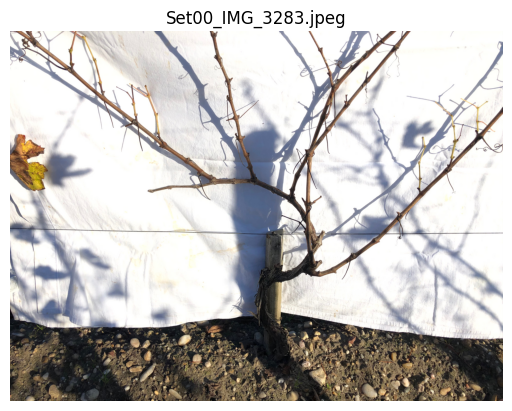

In [7]:
#mostrar una imagen
img_path = sample_files[0]
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title(img_path.name)
plt.axis("off")
plt.show()


In [8]:
#cargar y mostrar su json asociado

img_path = sample_files[0]
print("Imagen:", img_path.name)

# buscar json basado en prefijo
json_candidates = list(img_path.parent.glob(img_path.stem + "_annotation.json"))

if len(json_candidates) == 0:
    print("No se encontró JSON para esta imagen")
else:
    json_path = json_candidates[0]
    print("JSON encontrado:", json_path.name)

    with open(json_path, "r") as f:
        annotation = json.load(f)

annotation



Imagen: Set00_IMG_3283.jpeg
JSON encontrado: Set00_IMG_3283_annotation.json


{'Title': '3D2Cut Grapevine Annotation',
 'VineImage': [{'ImageFileName': 'IMG_3283.jpeg',
   'AnnotationVersion': '1.0.0',
   'AnnotationCoordinateSystem': 'TopLeft',
   'VineInfo': {'VineCountry': 'France',
    'VineRegion': 'Bordeaux',
    'VineVariety': ''},
   'ImageBackground': {'BackgroundType': 'artificialSheet',
    'BackgroundSheetColour': 'white'},
   'VineFeature': [[{'FeatureID': 0,
      'FeatureType': 'rootCrown',
      'FeatureCoordinates': [2205.0, 2715.0],
      'ParentID': None,
      'BranchLabel': 'root',
      'Annotator': 'Jerome',
      'AnnotationTool': 'semi auto',
      'AnnotationDate': '2021-04-15T13:27:40.097478UTC'},
     {'FeatureID': 1,
      'FeatureType': 'branchNode',
      'FeatureCoordinates': [2228.0, 2529.0],
      'ParentID': 0,
      'BranchLabel': 'mainTrunk',
      'Annotator': 'Jerome',
      'AnnotationTool': 'semi auto',
      'AnnotationDate': '2021-04-15T13:27:40.097478UTC'},
     {'FeatureID': 2,
      'FeatureType': 'pruningCut',
     

(np.float64(-0.5), np.float64(4031.5), np.float64(3023.5), np.float64(-0.5))

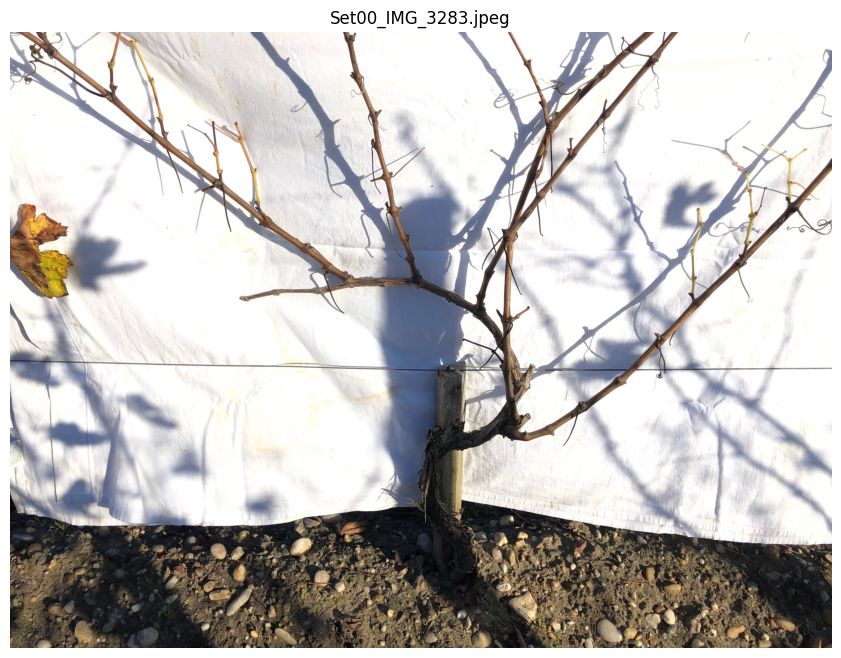

In [9]:
import matplotlib.pyplot as plt
import cv2

# Cargar imagen y plot normalizado a RGB
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.title(img_path.name)
plt.axis("off")


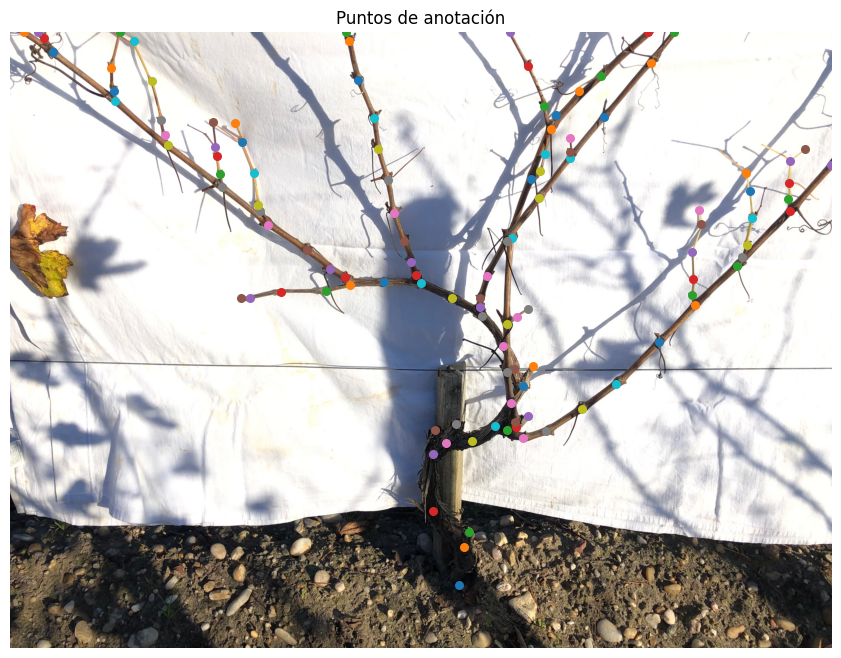

In [10]:
features = annotation["VineImage"][0]["VineFeature"][0]

plt.figure(figsize=(12,8))
plt.imshow(img_rgb)

for feat in features:
    x, y = feat["FeatureCoordinates"]
    plt.scatter(x, y, s=30, marker="o")

plt.title("Puntos de anotación")
plt.axis("off")
plt.show()


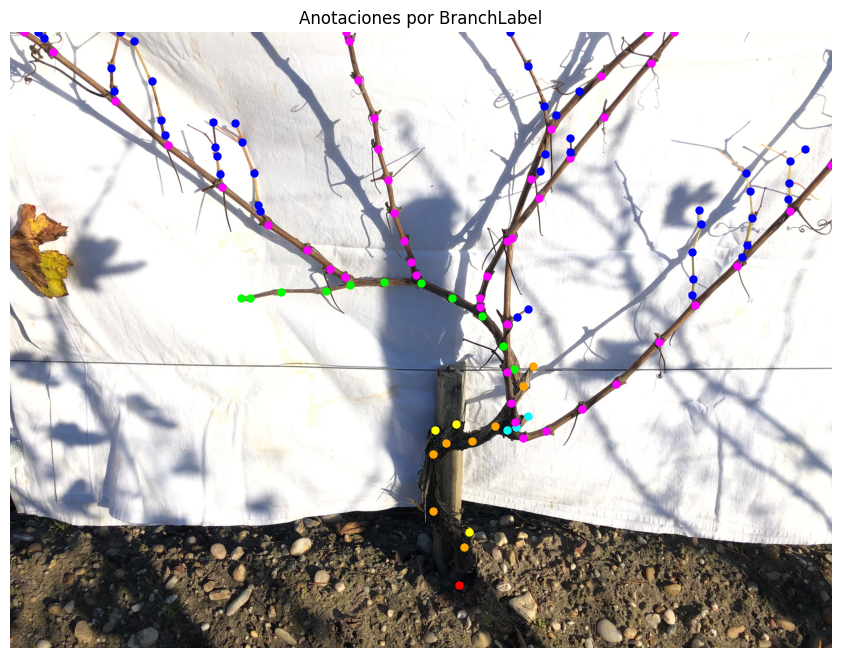

In [11]:
branch_colors = {
    "root": "red",            # base del tronco
    "mainTrunk": "orange",    # tronco principal
    "oldWood": "yellow",      # madera vieja
    "cane": "lime",           # pulgares largos
    "courson": "cyan",        # pulgares cortos
    "shoot": "magenta",       # brotes 1 año
    "lateralShoot": "blue",   # brotes laterales
}


plt.figure(figsize=(12,8))
plt.imshow(img_rgb)

for feat in features:
    x, y = feat["FeatureCoordinates"]
    branch = feat["BranchLabel"]
    plt.scatter(
        x, y, 
        s=25, 
        color=branch_colors.get(branch, "white"), 
        label=branch
    )

plt.title("Anotaciones por BranchLabel")
plt.axis("off")
plt.show()


In [12]:
from collections import Counter

types = [f["FeatureType"] for f in features]
Counter(types)


Counter({'branchNode': 91,
         'growingTip': 9,
         'branchToPhotoEdge': 8,
         'pruningCut': 6,
         'rootCrown': 1})

In [13]:
all_png = sorted(raw_path.rglob("*.jpeg"))  # o .png según corresponda
len(all_png)


899

In [113]:
def segment_vine_rgb(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Ajustar según el fondo (blanco / azul)
    lower = np.array([0, 0, 121])
    upper = np.array([190, 150, 255])

    mask = cv2.inRange(hsv, lower, upper)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask


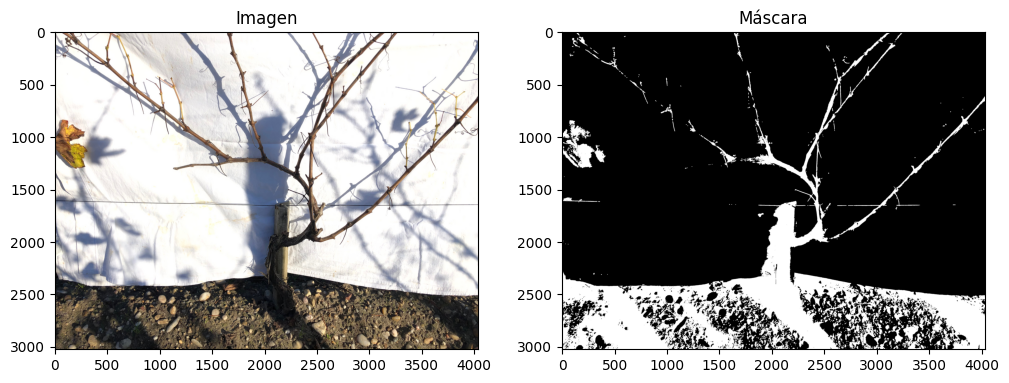

In [117]:
mask_vine = cv2.bitwise_not(segment_vine_rgb(img_rgb))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Imagen")

plt.subplot(1,2,2)
plt.imshow(mask_vine, cmap="gray")
plt.title("Máscara")
plt.show()


In [118]:
kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask_vine, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

(np.float64(-0.5), np.float64(4031.5), np.float64(3023.5), np.float64(-0.5))

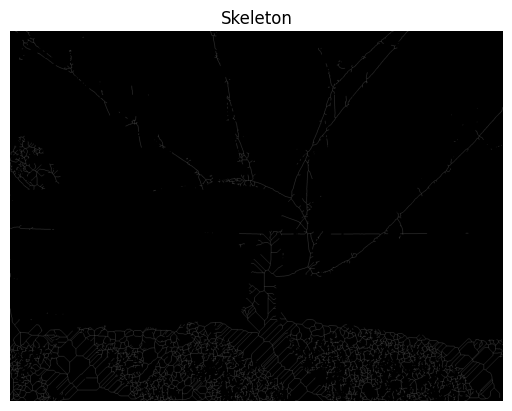

In [119]:
from skimage.morphology import skeletonize

binary = mask_clean > 0
skeleton = skeletonize(binary)

plt.imshow(skeleton, cmap="gray")
plt.title("Skeleton")
plt.axis("off")


(np.float64(-0.5), np.float64(4031.5), np.float64(3023.5), np.float64(-0.5))

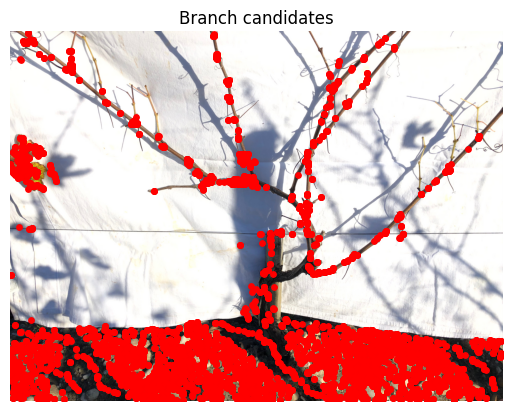

In [121]:
import scipy.ndimage as ndi

neighbors = ndi.convolve(skeleton.astype(int),
                          np.ones((3,3)), mode='constant')

branch_points = (neighbors >= 4) & skeleton

ys, xs = np.where(branch_points)

plt.imshow(img_rgb)
plt.scatter(xs, ys, s=15, c="red")
plt.title("Branch candidates")
plt.axis("off")


(np.float64(-0.5), np.float64(4031.5), np.float64(3023.5), np.float64(-0.5))

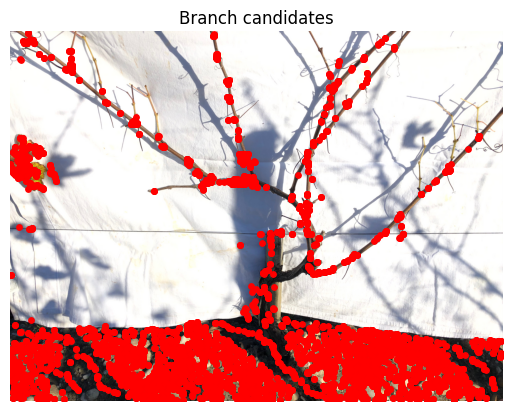

In [122]:
import scipy.ndimage as ndi

neighbors = ndi.convolve(skeleton.astype(int),
                          np.ones((3,3)), mode='constant')

branch_points = (neighbors >= 4) & skeleton

ys, xs = np.where(branch_points)

plt.imshow(img_rgb)
plt.scatter(xs, ys, s=15, c="red")
plt.title("Branch candidates")
plt.axis("off")



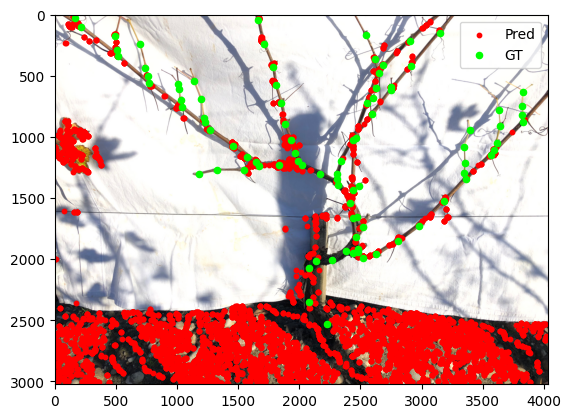

In [123]:
gt_points = [
    feat["FeatureCoordinates"]
    for feat in features
    if feat["FeatureType"] == "branchNode"
]

gt_x, gt_y = zip(*gt_points)

plt.imshow(img_rgb)
plt.scatter(xs, ys, c="red", s=10, label="Pred")
plt.scatter(gt_x, gt_y, c="lime", s=20, label="GT")
plt.legend()
plt.show()
